In [1]:
from engine.predictor import DefaultPredictor
from config.config import get_cfg
from model.rcnn import GeneralizedRCNN
import torch
import cv2
import matplotlib.pyplot as plt
from data.pascal_voc import VOC_CLASS_NAMES
import copy
# from utils.visualizer import Visualizer
from data.catalog import MetadataCatalog, DatasetCatalog

print(torch.cuda.device_count())
torch.cuda.set_device(2)
print(torch.cuda.current_device())

4
2


In [2]:
cfg = get_cfg()
cfg.MODEL.ROI_HEADS.NUM_CLASSES  = 20
cfg.MODEL.RPN.USE_MDN = True
model = GeneralizedRCNN(cfg).to('cuda')
state_dict = torch.load('./ckpt/mdn_17500.pt')
model.load_state_dict(state_dict)
predictor = DefaultPredictor(cfg,model)

USE MDN


/data/private/faster_rcnn_rilab/model/rpn/rpn_mdn.py:42: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)
/data/private/faster_rcnn_rilab/model/rpn/rpn_mdn.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)


## Inference

In [3]:
img = cv2.imread('input.png')


In [4]:
pred = predictor(img)
pred = pred['instances']._fields

In [5]:
pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.5)[0]

pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]

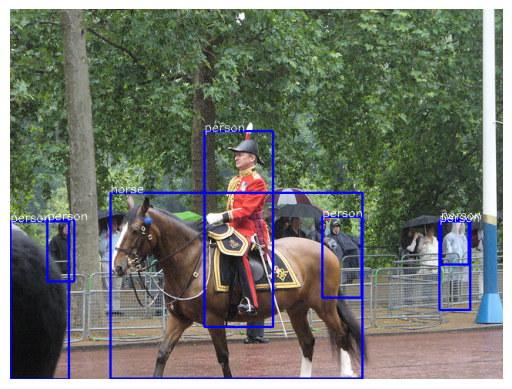

In [6]:

demo_image = copy.deepcopy(img)
for bbox,label in zip(pred_boxes,pred_classes):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (255, 0, 0), 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

In [7]:
# #

## RPN

In [9]:
pred = predictor.proposal_predict(img)[0]
pred = pred['instances']._fields
proposal_boxes = pred['proposal_boxes'].tensor
objectness = pred['objectness_logits']
objectness = torch.sigmoid(objectness)
print(proposal_boxes.shape)
index = torch.where(objectness>0.2)[0]

proposal_boxes = proposal_boxes[index]

torch.Size([16, 4])


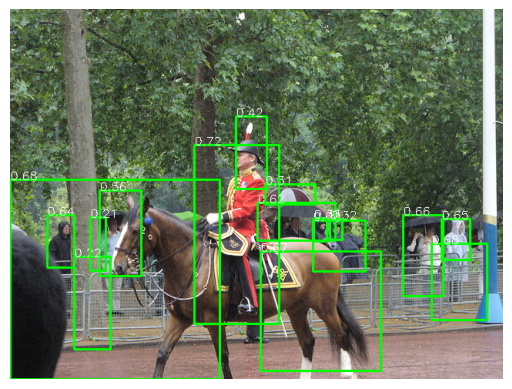

In [10]:
demo_image = copy.deepcopy(img)
for bbox,score in zip(proposal_boxes,objectness):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, 255, 0), 2)
    cv2.putText(demo_image, str(round(score.item(),2)), 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

## Uncertainty

In [11]:
pred = predictor.uncertainty_predict(img)[0]
pred = pred['instances']._fields

torch.Size([1, 50250]) torch.Size([1, 50250])


In [12]:
proposal_boxes = pred['proposal_boxes'].tensor
epis = pred['epis']
alea = pred['alea']
print(epis.shape,proposal_boxes.shape)

torch.Size([16]) torch.Size([16, 4])


In [21]:
min_epis = torch.min(epis).item()
max_epis = torch.max(epis).item()

min_alea = torch.min(alea).item()
max_alea = torch.max(alea).item()

def scale(e,a):
    return (e-min_epis)/(max_epis-min_epis),(a-min_alea)/(max_alea-min_alea)

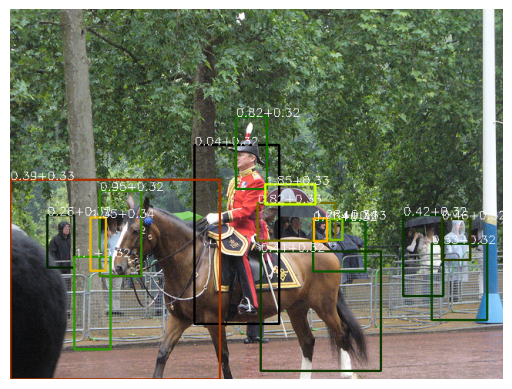

In [24]:
demo_image = copy.deepcopy(img)
for bbox,e,a in zip(proposal_boxes,epis,alea):
    e = e.item()
    a = a.item()
    se,sa = scale(e,a)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, int(255*se), int(255*sa)), 2)
    cv2.putText(demo_image, str(round(e,2))+'+' +str(round(a,2)), 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

In [23]:
print(alea)
print(epis)

tensor([0.3171, 0.3179, 0.3182, 0.3304, 0.3183, 0.3178, 0.3205, 0.3177, 0.3263,
        0.3215, 0.3189, 0.3373, 0.3269, 0.3331, 0.3206, 0.3359],
       device='cuda:2')
tensor([0.0374, 0.6511, 0.5276, 0.3897, 0.4074, 0.4236, 0.4624, 0.2599, 0.8150,
        0.9489, 0.8220, 1.2830, 1.4019, 1.8459, 1.1036, 1.3479],
       device='cuda:2')
